In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  # 词形还原
from gensim.models import word2vec
from tensorflow.keras.models import Sequential
import re
import numpy as np
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Input
import matplotlib.pyplot as plt

In [2]:
keras.preprocessing.text.Tokenizer(num_words=None,
                                   filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n',
                                   lower=True,
                                   split=" ",
                                   char_level=False)
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>', num_words=None)  # 构造分词器

In [3]:
training_set = pd.read_csv('second_train.csv')
train_text = training_set['text']
train_text_list = []  # 文本的列表形式
#nltk.download('stopwords')  # 下载停用词表
StopWords = stopwords.words('english')  # 停用词表

for i in range(len(train_text)):  # 将训练集文本转为列表形式存储
    train_text_list.append(train_text[i])

In [8]:
print(training_set)

        id  label                                               text
0        0      4  dr. goldberg offers everything i look for in a...
1        1      0  Terrible. Preordered my tires and when I arriv...
2        2      0  The delivery driver mistakenly rang my doorbel...
3        3      3  OK, its Friday night and have about 70 minutes...
4        4      0  My expectations for McDonalds are t rarely hig...
...    ...    ...                                                ...
7996  7996      1  Nothing impressive, even on the cheesy side. W...
7997  7997      0  Me and my friends decided to come here on a sa...
7998  7998      2  Got there after 12 so the guest passes were vo...
7999  7999      0  If only I could give this place 0 stars. Wow. ...
8000  8000      1  Went to The Bank because I was invited to a pr...

[8001 rows x 3 columns]


In [4]:
test_data = pd.read_csv('test.csv')
test_text = test_data['text']
test_text_list = [i for i in test_text]
print(len(test_text_list))

20001


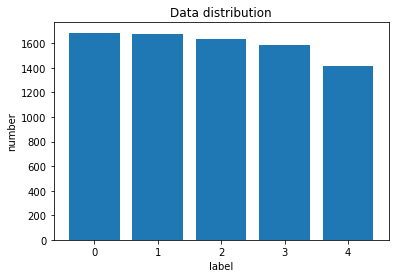

{4: 1419, 0: 1687, 3: 1584, 1: 1679, 2: 1632}


In [5]:
labels = list(training_set['label'])
category = {}
for i in labels:
    category[i] = labels.count(i)
# 画图
x=[]
y=[]
for key, value in category.items():
    x.append(key)
    y.append(value)
plt.bar(x, y)    
plt.title('Data distribution')
plt.ylabel('number')
plt.xlabel('label')
plt.show()
print(category)    

In [6]:
# 提取标签并转成one_hot矩阵
train_label = training_set['label']
train_label_list = [i for i in train_label]
train_label_one_hot = np.eye(5)[train_label_list]
print(train_label_one_hot)

[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [1]:
pip install pyenchant

Note: you may need to restart the kernel to use updated packages.


In [23]:
nltk.download("wordnet")  # 下载词典
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\92703\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\92703\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\92703\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [7]:
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag  # 用word_tokenize进行分词能更好地得到正确的词性
lemmatizer = WordNetLemmatizer()

In [8]:
def get_wordnet_pos(pos_tag):
    """
    将pos_tag标注的词性转为wordnet标注的词性
    """
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [9]:
def text_normalization(text_list):
    """
    文本清洗
    """
    corpus = []  # 语料
    for sentence in text_list:
        sentence = sentence.lower()  # 全部转为小写
        sentence = re.sub(r'[^a-zA-Z0-9]', " ", sentence)  # 把字母及数字之外的字符用空格代替
        # 去除url
        result = re.compile(r'http://[a-zA-Z0-9.?/&=:]*',re.S)
        sentence = result.sub("",sentence)
        # 分词、去停用词及词形还原
        words = word_tokenize(sentence)
        pos = pos_tag(words)  # 获取pos_tag版的词性
        for word in words: 
            loc = words.index(word)
            if word in StopWords:
                words.remove(word)
            else:    
                wordnet_pos = get_wordnet_pos(pos[loc][1]) 
                words[loc] = lemmatizer.lemmatize(word, pos=wordnet_pos)
        corpus.append(words)
    return corpus 

In [10]:
train_corpus = text_normalization(train_text_list)  # 将句子分词，形成[['a','b'],['c']]形式的语料
print(len(train_corpus))

8001


In [11]:
test_corpus = text_normalization(test_text_list)
print(len(test_corpus))

20001


In [12]:
total_corpus = train_corpus + test_corpus
print(len(total_corpus))

28002


In [13]:
# word2vec参数
vector_size = 100  # 向量维度
min_word_frequency = 3  # 词出现的次数不能少于3次
window_size = 4  # 上下文窗口大小
num_core = 4  # cpu工作的核心数
# word2vec模型
embedding_model = word2vec.Word2Vec(total_corpus, workers=num_core, vector_size=vector_size, window=window_size,
                                    min_count=min_word_frequency)
embedding_model.init_sims(replace=True)  # 只保留按行归一化的向量，节省内存

C:\Users\92703\AppData\Local\Temp/ipykernel_162232/2999090037.py:9: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  embedding_model.init_sims(replace=True)  # 只保留按行归一化的向量，节省内存


In [14]:
embedding_model.save("yelp_W2V_model")  
print(embedding_model)

Word2Vec(vocab=20991, vector_size=100, alpha=0.025)


In [15]:
tokenizer.fit_on_texts(total_corpus)  # 载入文本
total_vocab = tokenizer.word_index  # 词表
print(total_vocab)            

{'<UNK>': 1, 'the': 2, 'a': 3, 'i': 4, 'was': 5, 'it': 6, 'place': 7, 'good': 8, 'food': 9, 't': 10, 'my': 11, 'you': 12, 'to': 13, 'get': 14, 'like': 15, 'time': 16, 'is': 17, 'have': 18, 'one': 19, 'not': 20, 'go': 21, 'they': 22, 'would': 23, 'we': 24, 'service': 25, 'this': 26, 'had': 27, 'great': 28, 's': 29, 'that': 30, 'back': 31, 'and': 32, 'really': 33, 'be': 34, 'were': 35, 'even': 36, 'in': 37, 'room': 38, 'for': 39, 'all': 40, 'of': 41, 'also': 42, 'just': 43, 'got': 44, 'nice': 45, 'are': 46, 'very': 47, 'come': 48, 'people': 49, 'well': 50, 'order': 51, 'our': 52, 'restaurant': 53, 'much': 54, 'never': 55, 'there': 56, 'could': 57, 'pretty': 58, 'little': 59, 'can': 60, 'know': 61, 've': 62, 'make': 63, 'first': 64, 'so': 65, 'say': 66, 'their': 67, 'night': 68, 'best': 69, 'ordered': 70, '2': 71, 'think': 72, 'always': 73, 'way': 74, 'm': 75, 'went': 76, 'price': 77, 'want': 78, 'day': 79, 'us': 80, 'an': 81, 'came': 82, 'bad': 83, 'better': 84, 'take': 85, 'table': 86, 

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_textID = tokenizer.texts_to_sequences(train_corpus)  # 将每段文本转成词表里对应的数字
train_sequence_padding = pad_sequences(train_textID, 100)  # 规定最大长度为100，不够就往前面补0
print(train_sequence_padding.shape)

(8001, 100)


In [17]:
test_textID = tokenizer.texts_to_sequences(test_corpus)  # 将每段文本转成词表里对应的数字
test_sequence_padding = pad_sequences(test_textID, 100)  # 规定最大长度为100，不够就往前面补0
print(test_sequence_padding.shape)

(20001, 100)


In [18]:
total_sequence_padding = np.vstack((test_sequence_padding,train_sequence_padding))
print(total_sequence_padding.shape)

(28002, 100)


In [19]:
# 创建embedding矩阵，每行为训练好的word2vec模型中与词典编号对应的词的向量（从第1行开始）
embedding_matrix = np.zeros((len(total_vocab)+1, vector_size))
for word, i in total_vocab.items():
    try:
        vector = embedding_model.wv[word]  # 在模型中提取词典中词的向量，若没有，则会报错KeyError
        embedding_matrix[i] = vector
    except KeyError:
        continue
print(embedding_matrix.shape)    

(50623, 100)


In [20]:
# 搭建神经网络
model_input = Input(shape=(100,), dtype="float64")  # 创建一个象征性的张量，目的是使得模型知道一开始输入的句子维度是多少
sub_embedding = Embedding(len(embedding_matrix), vector_size, weights=[embedding_matrix], trainable=False) # 不在训练的过程中更新词向量
cnn_model = Sequential()
cnn_model.add(model_input)
cnn_model.add(sub_embedding)  
#cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(260, kernel_size=4, padding='same', activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(MaxPooling1D(4))
cnn_model.add(Conv1D(260, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(MaxPooling1D(4))
cnn_model.add(Flatten())

#cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(260, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(units=5, activation='softmax'))
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(cnn_model.summary())
# 训练模型
yelp_cnn = cnn_model.fit(train_sequence_padding, train_label_one_hot, batch_size=100, epochs=21,
                        validation_split=0.2)
cnn_model.save('yelp_cnn')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          5062300   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 260)          104260    
_________________________________________________________________
dropout (Dropout)            (None, 100, 260)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 260)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 260)           203060    
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 260)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 260)            0

In [21]:
ave = 0
num = 0
for i in yelp_cnn.history['val_accuracy']:
    if i > 0.46:
        ave += i
        num +=1
ave = ave / num        
print(ave)

0.4829702026703778


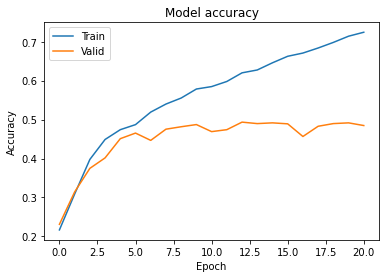

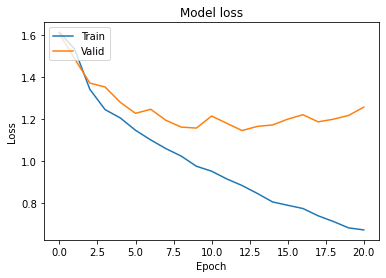

In [83]:
plt.plot(yelp_cnn.history['accuracy'])
plt.plot(yelp_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

plt.plot(yelp_cnn.history['loss'])
plt.plot(yelp_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

Text(0.5, 51.0, 'prediction')

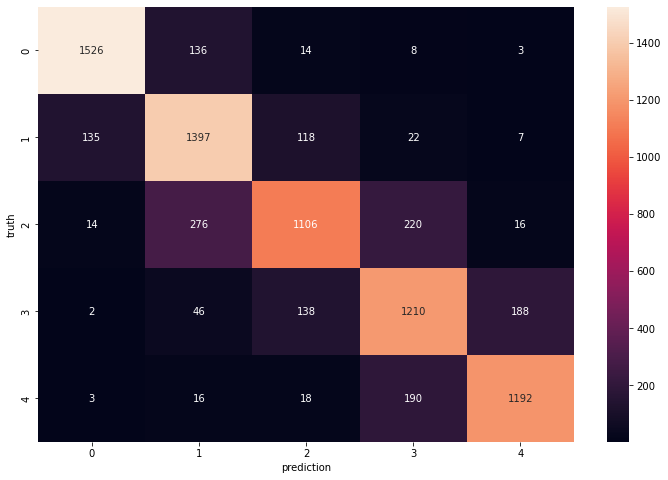

In [39]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
trained_model = keras.models.load_model('yelp_cnn')

train_pred = trained_model.predict(train_sequence_padding)
train_pred = np.argmax(train_pred, axis=1)
train_truth = train_label_list
 
#生成混淆矩阵
confuse_matrix = confusion_matrix(train_truth, train_pred)
fig, ax = plt.subplots(figsize=(12,8))
# 画图
sns.heatmap(confuse_matrix, annot=True, fmt='d',xticklabels=[i for i in range(5)], yticklabels=[i for i in range(5)])
plt.ylabel('truth')
plt.xlabel('prediction')

In [149]:
trained_model = keras.models.load_model('yelp_cnn')
test_predict = trained_model.predict(test_sequence_padding)
test_predict = np.argmax(test_predict, axis=1)

In [151]:
print(test_predict)

[0 0 0 ... 0 1 1]


In [150]:
pd.DataFrame(test_predict).to_csv('prediction.csv')